In [ ]:
! pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from keras.utils import to_categorical
from tqdm import tqdm
import torch.optim as optim
import category_encoders as ce
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving indiancrop_dataset.csv to indiancrop_dataset (1).csv


Context: Precision agriculture is in trend nowadays. It helps the farmers to get informed decision about the farming strategy. Here, I present you a dataset which would allow the users to build a predictive model to recommend the most suitable crops to grow in a particular farm based on various parameters.

Features:
*  N - ratio of Nitrogen content in soil
*  P - ratio of Phosphorous content in soil
*  K - ratio of Potassium content in soil
*  temperature - temperature in degree Celsius
*  humidity - relative humidity in %
*  ph - ph value of the soil
*  rainfall - rainfall in mm


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['indiancrop_dataset.csv']))

In [ ]:
df.head()

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,STATE,CROP_PRICE,CROP
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Andaman and Nicobar,7000,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Andaman and Nicobar,5000,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Andaman and Nicobar,7000,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Andaman and Nicobar,7000,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Andaman and Nicobar,120000,Rice


In [ ]:
features = df.loc[:, df.columns != 'CROP'].columns
features

Index(['N_SOIL', 'P_SOIL', 'K_SOIL', 'TEMPERATURE', 'HUMIDITY', 'ph',
       'RAINFALL', 'STATE', 'CROP_PRICE'],
      dtype='object')

In [ ]:
classes = df['CROP'].unique()
classes

array(['Rice', 'Maize', 'ChickPea', 'KidneyBeans', 'PigeonPeas',
       'MothBeans', 'MungBean', 'Blackgram', 'Lentil', 'Pomegranate',
       'Banana', 'Mango', 'Grapes', 'Watermelon', 'Muskmelon', 'Apple',
       'Orange', 'Papaya', 'Coconut', 'Cotton', 'Jute', 'Coffee'],
      dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N_SOIL       2200 non-null   int64  
 1   P_SOIL       2200 non-null   int64  
 2   K_SOIL       2200 non-null   int64  
 3   TEMPERATURE  2200 non-null   float64
 4   HUMIDITY     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   RAINFALL     2200 non-null   float64
 7   STATE        2200 non-null   object 
 8   CROP_PRICE   2200 non-null   int64  
 9   CROP         2200 non-null   object 
dtypes: float64(4), int64(4), object(2)
memory usage: 172.0+ KB


In [ ]:
#check null value
df.isnull().sum()

N_SOIL         0
P_SOIL         0
K_SOIL         0
TEMPERATURE    0
HUMIDITY       0
ph             0
RAINFALL       0
STATE          0
CROP_PRICE     0
CROP           0
dtype: int64

<Axes: >

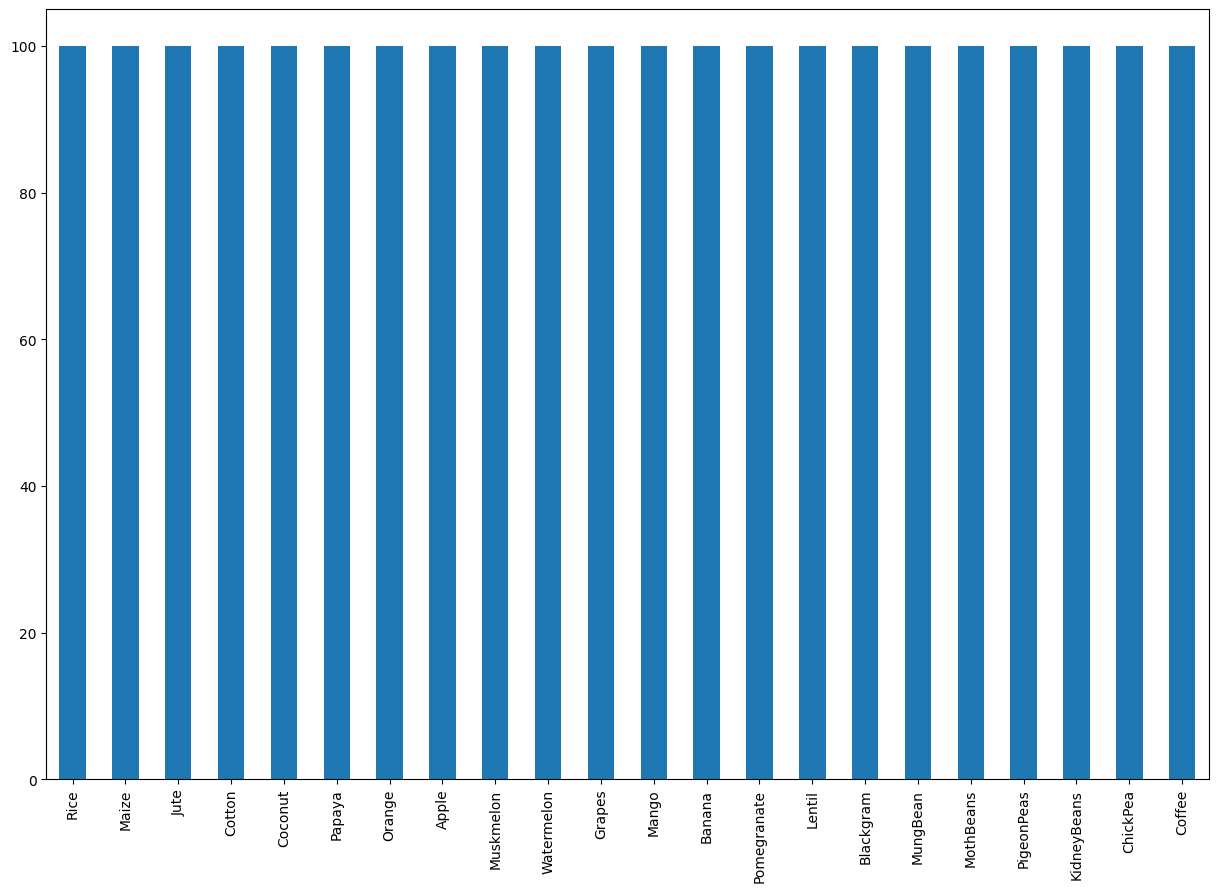

In [ ]:
# Distribution of responses
df['CROP'].value_counts().plot(kind='bar')

In [ ]:
#feature exploration analysis
for i in features:
  f = plt.figure(figsize=(20,4))
  f.add_subplot(1,2,1)
  sns.distplot(df.loc[:, i])
  f.add_subplot(1,2,2)
  sns.boxplot(df.loc[:, i])


In [ ]:
state_encoder=ce.OneHotEncoder(cols='STATE',return_df=True,use_cat_names=True)
df = state_encoder.fit_transform(df)
# Split the data into features (X) and target (y)
X = df.drop('CROP', axis=1)
X = X.drop('CROP_PRICE', axis=1)
y = df['CROP'].astype("category")
y = y.cat.codes

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,STATE_Andaman and Nicobar,STATE_Andhra Pradesh,STATE_Assam,...,STATE_Odisha,STATE_Pondicherry,STATE_Punjab,STATE_Rajasthan,STATE_Tamil Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar Pradesh,STATE_Uttrakhand,STATE_West Bengal
803,11,74,17,21.363838,69.923759,6.633865,46.635286,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,37,79,19,27.543848,69.347863,7.143943,69.408782,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1828,16,14,30,29.709313,96.304843,6.374668,209.845399,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1407,114,30,51,29.249085,90.069981,6.069172,25.934965,0,0,0,...,0,0,0,0,1,0,0,0,0,0
750,26,67,16,29.107131,67.905774,7.176208,67.833459,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,82,48,36,25.793520,81.769040,6.352077,193.241838,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1395,97,12,47,25.287846,89.636679,6.765095,58.286977,0,0,0,...,0,0,0,0,1,0,0,0,0,0
626,13,57,25,28.300415,86.206816,6.863086,50.473339,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1993,101,37,18,22.923610,82.687385,7.637378,92.919151,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## KNN

In [ ]:
k_range = range(1, 31)
param_grid = dict(weights=['uniform', 'distance'],
                  n_neighbors=k_range)
print(param_grid)

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'weights': ['uniform', 'distance'], 'n_neighbors': range(1, 31)}


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
knn_result = pd.DataFrame(grid.cv_results_)
knn_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006971,0.006668,0.032663,0.048583,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.988636,0.965909,0.988636,0.982955,0.988636,0.971591,0.971591,0.977273,0.994318,0.971591,0.980114,0.009249,7
1,0.003724,0.000205,0.006964,0.000577,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.988636,0.965909,0.988636,0.982955,0.988636,0.971591,0.971591,0.977273,0.994318,0.971591,0.980114,0.009249,7
2,0.004138,0.000792,0.012565,0.002089,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.971591,0.977273,0.977273,0.977273,0.982955,0.977273,0.971591,0.954545,0.977273,0.948864,0.971591,0.010477,29
3,0.003984,0.000600,0.007500,0.001294,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.988636,0.965909,0.988636,0.982955,0.988636,0.971591,0.971591,0.977273,0.994318,0.971591,0.980114,0.009249,7
4,0.004714,0.002874,0.011616,0.000928,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.971591,0.977273,0.988636,0.982955,0.994318,0.988636,0.971591,0.965909,0.988636,0.977273,0.980682,0.008875,3
5,0.003782,0.000553,0.007724,0.002779,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.971591,0.977273,0.988636,0.982955,0.994318,0.988636,0.971591,0.965909,0.988636,0.977273,0.980682,0.008875,3
6,0.003652,0.000125,0.011443,0.000565,4,uniform,"{'n_neighbors': 4, 'weights': 'uniform'}",0.971591,0.977273,0.982955,0.977273,0.988636,0.982955,0.977273,0.960227,0.971591,0.965909,0.975568,0.008055,20
7,0.003506,0.000084,0.006898,0.000215,4,distance,"{'n_neighbors': 4, 'weights': 'distance'}",0.971591,0.971591,0.988636,0.988636,0.994318,0.988636,0.971591,0.971591,0.994318,0.971591,0.981250,0.009858,2
8,0.003991,0.000720,0.013583,0.005035,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.977273,0.971591,0.988636,0.977273,0.994318,0.988636,0.982955,0.965909,0.977273,0.977273,0.980114,0.008135,10
9,0.003637,0.000333,0.006746,0.000160,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.977273,0.971591,0.988636,0.977273,0.994318,0.988636,0.982955,0.971591,0.977273,0.977273,0.980682,0.007276,6


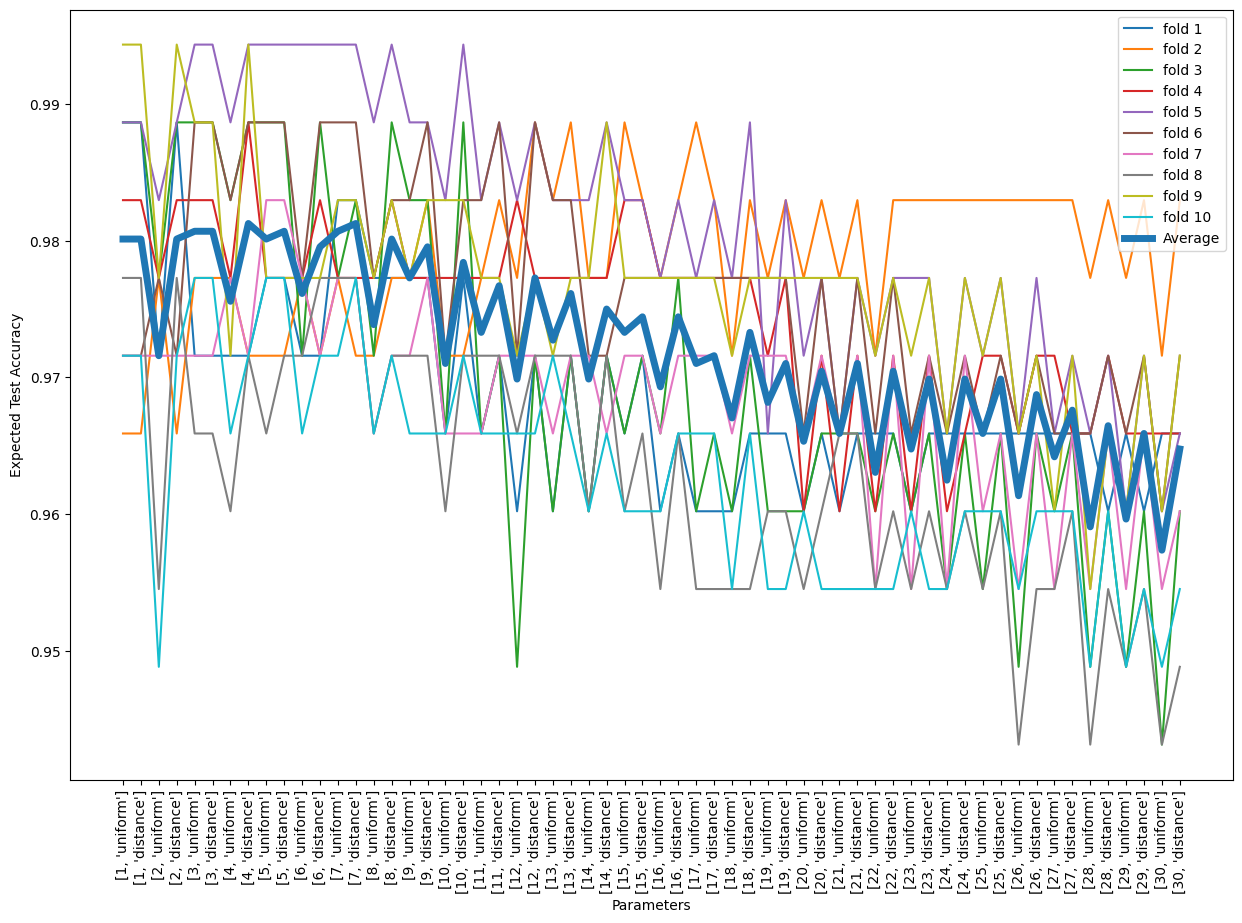

In [ ]:
labels = list()
for i in range(len(knn_result['params'])):
  labels.append(list(knn_result['params'][i].values()))
x = range(60)
y_1 = knn_result['split0_test_score']
y_2 = knn_result['split1_test_score']
y_3 = knn_result['split2_test_score']
y_4 = knn_result['split3_test_score']
y_5 = knn_result['split4_test_score']
y_6 = knn_result['split5_test_score']
y_7 = knn_result['split6_test_score']
y_8 = knn_result['split7_test_score']
y_9 = knn_result['split8_test_score']
y_10 = knn_result['split9_test_score']
y_avg = knn_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.show()

In [ ]:
print('Best n_neighbors:', grid.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', grid.best_estimator_.get_params()['weights'])

Best n_neighbors: 7
Best weights: distance


In [ ]:
best_knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance')
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

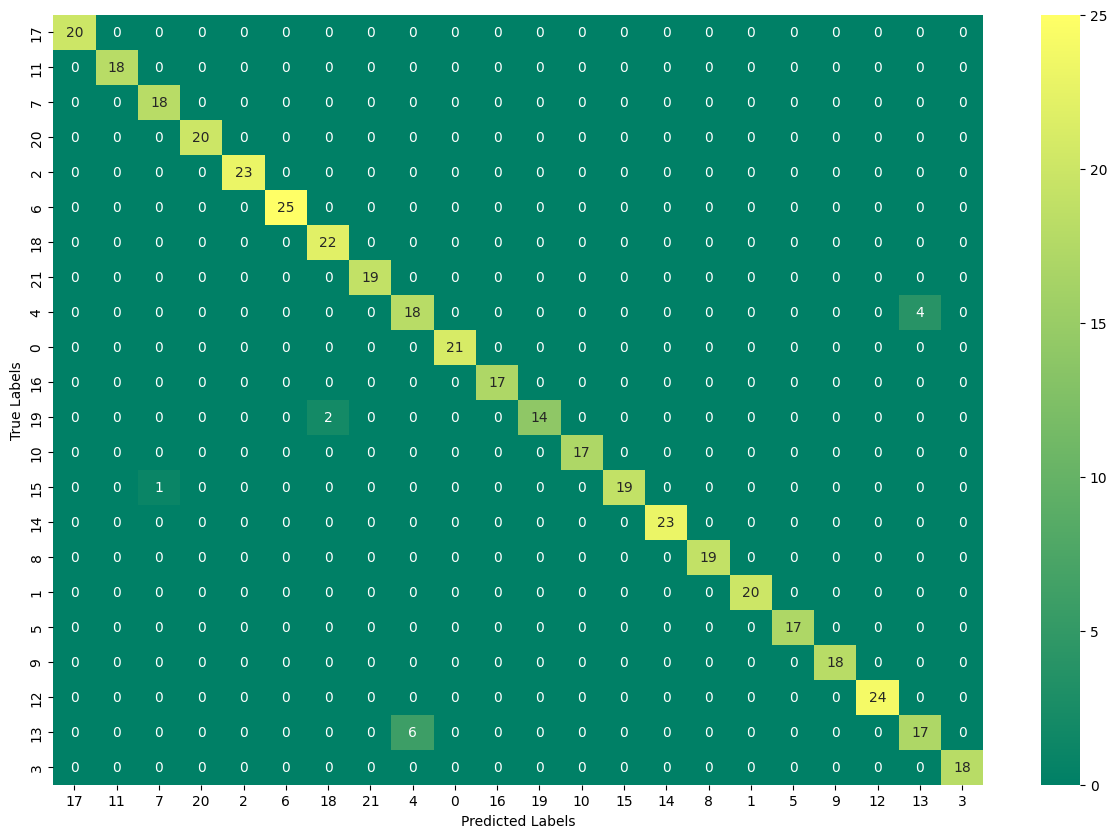

In [ ]:
y_pred = best_knn_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
def accuracy(y_true, y_pred):

    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score

    """

    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = (y_true == y_pred).sum()

    #returns accuracy
    return correct_predictions / len(y_true)

In [ ]:
accuracy(np.array(y_test), y_pred)

0.9704545454545455

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")

Macro-Averaged Precision score: 0.9737981316928686
Micro-Averaged Precision score: 0.9704545454545455


In [ ]:
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")

Macro-averaged recall score: 0.9719232842256559
Micro-Averaged recall score: 0.9704545454545455


In [ ]:
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged F1 score: 0.9723874085534164
Micro-Averaged F1 score: 0.9704545454545455


## Logistic Regression

In [ ]:
param_grid = dict(penalty = ['l1', 'l2', None],
                  C = np.logspace(-3, 3, 7),
                  solver = ['lbfgs', 'liblinear', 'saga'])
print(param_grid)

grid = GridSearchCV(LogisticRegression(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'penalty': ['l1', 'l2', None], 'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['lbfgs', 'liblinear', 'saga']}


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2', None],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [ ]:
logistic_result = pd.DataFrame(grid.cv_results_)
logistic_result = logistic_result[-logistic_result['mean_test_score'].isnull()]
logistic_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
1,0.061871,0.004734,0.003419,0.000940,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.630682,0.625000,...,0.590909,0.602273,0.590909,0.590909,0.590909,0.585227,0.625000,0.604545,0.016507,49
2,1.118312,0.266721,0.003687,0.000253,0.001,l1,saga,"{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}",0.704545,0.721591,...,0.693182,0.715909,0.727273,0.698864,0.687500,0.687500,0.698864,0.703409,0.013154,48
3,0.288071,0.089204,0.003970,0.000391,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.931818,0.954545,...,0.926136,0.943182,0.948864,0.965909,0.892045,0.948864,0.954545,0.939773,0.019715,43
4,0.071560,0.008483,0.002889,0.000259,0.001,l2,liblinear,"{'C': 0.001, 'penalty': 'l2', 'solver': 'libli...",0.926136,0.931818,...,0.892045,0.931818,0.931818,0.926136,0.875000,0.943182,0.920455,0.920455,0.019682,46
5,0.882577,0.208206,0.003489,0.000460,0.001,l2,saga,"{'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}",0.931818,0.937500,...,0.926136,0.943182,0.948864,0.965909,0.886364,0.948864,0.954545,0.937500,0.020486,44
6,0.306237,0.093148,0.004059,0.001403,0.001,None,lbfgs,"{'C': 0.001, 'penalty': None, 'solver': 'lbfgs'}",0.971591,0.977273,...,0.960227,0.948864,0.988636,0.982955,0.954545,0.965909,0.977273,0.967614,0.013458,12
8,0.823236,0.070518,0.003268,0.000608,0.001,None,saga,"{'C': 0.001, 'penalty': None, 'solver': 'saga'}",0.943182,0.960227,...,0.954545,0.948864,0.960227,0.965909,0.909091,0.943182,0.977273,0.951136,0.017271,26
10,0.239985,0.027668,0.003861,0.000776,0.01,l1,liblinear,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.897727,0.926136,...,0.869318,0.920455,0.920455,0.926136,0.880682,0.937500,0.897727,0.907955,0.020768,47
11,1.095983,0.166843,0.003506,0.000517,0.01,l1,saga,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}",0.909091,0.943182,...,0.909091,0.926136,0.943182,0.943182,0.880682,0.943182,0.937500,0.925568,0.019919,45
12,0.357311,0.154431,0.003789,0.000358,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.977273,0.965909,...,0.960227,0.965909,0.977273,0.977273,0.931818,0.948864,0.971591,0.963068,0.013975,22


In [ ]:
list(logistic_result['params'].index)

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 17,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 55,
 56,
 57,
 58,
 59,
 60,
 62]

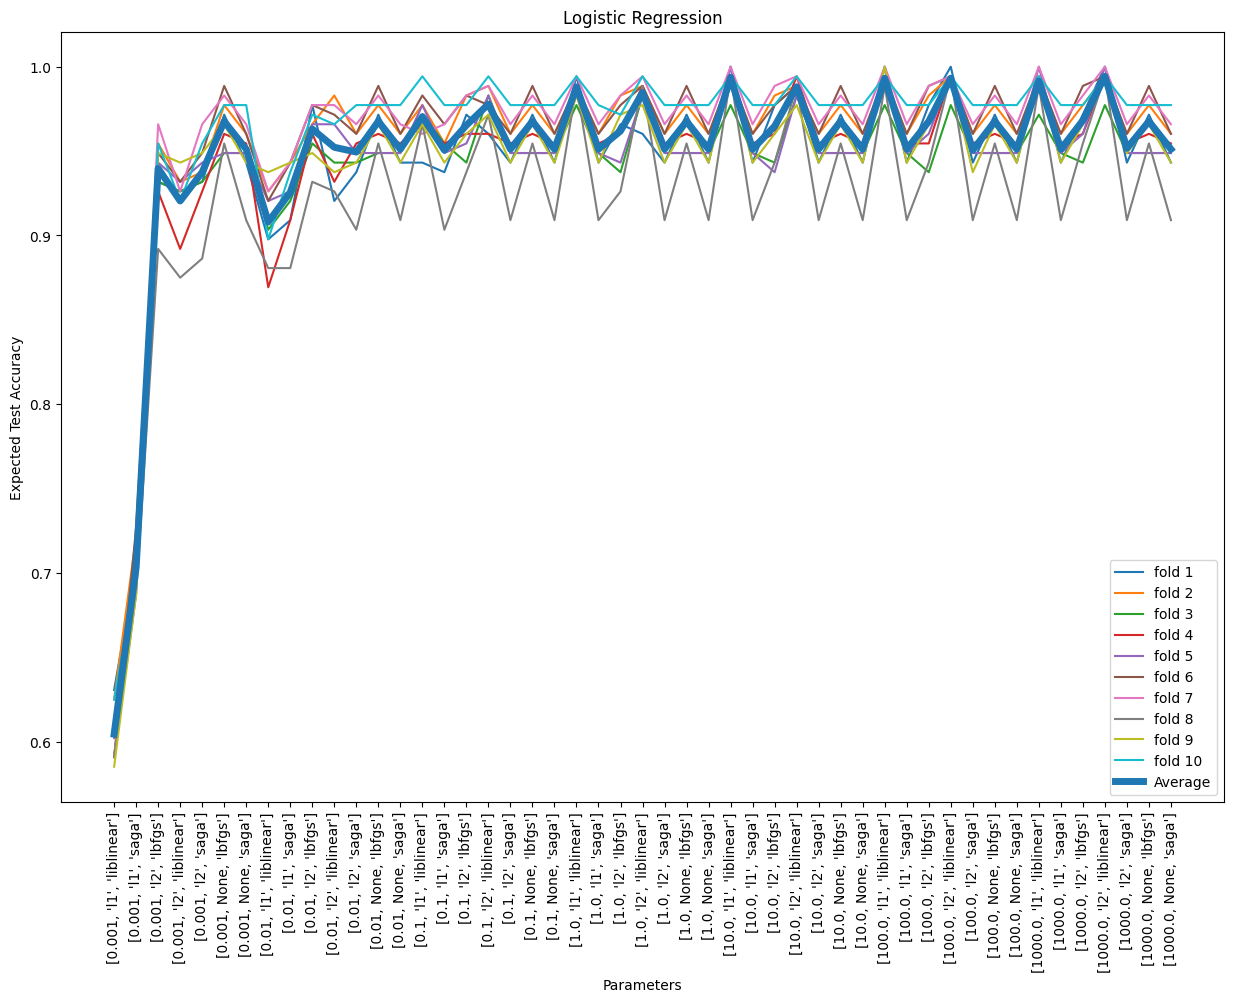

In [ ]:
labels = list()
for i in list(logistic_result['params'].index):
  labels.append(list(logistic_result['params'][i].values()))
x = range(49)
y_1 = logistic_result['split0_test_score']
y_2 = logistic_result['split1_test_score']
y_3 = logistic_result['split2_test_score']
y_4 = logistic_result['split3_test_score']
y_5 = logistic_result['split4_test_score']
y_6 = logistic_result['split5_test_score']
y_7 = logistic_result['split6_test_score']
y_8 = logistic_result['split7_test_score']
y_9 = logistic_result['split8_test_score']
y_10 = logistic_result['split9_test_score']
y_avg = logistic_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("Logistic Regression")
plt.show()

In [ ]:
print('Best C:', grid.best_estimator_.get_params()['C'])
print('Best Penalty:', grid.best_estimator_.get_params()['penalty'])
print('Best Solver:', grid.best_estimator_.get_params()['solver'])

Best C: 1000.0
Best Penalty: l2
Best Solver: liblinear


In [ ]:
best_logistic_model = LogisticRegression(C=1000, penalty='l2', solver='liblinear')
best_logistic_model.fit(X_train, y_train)

LogisticRegression(C=1000, solver='liblinear')

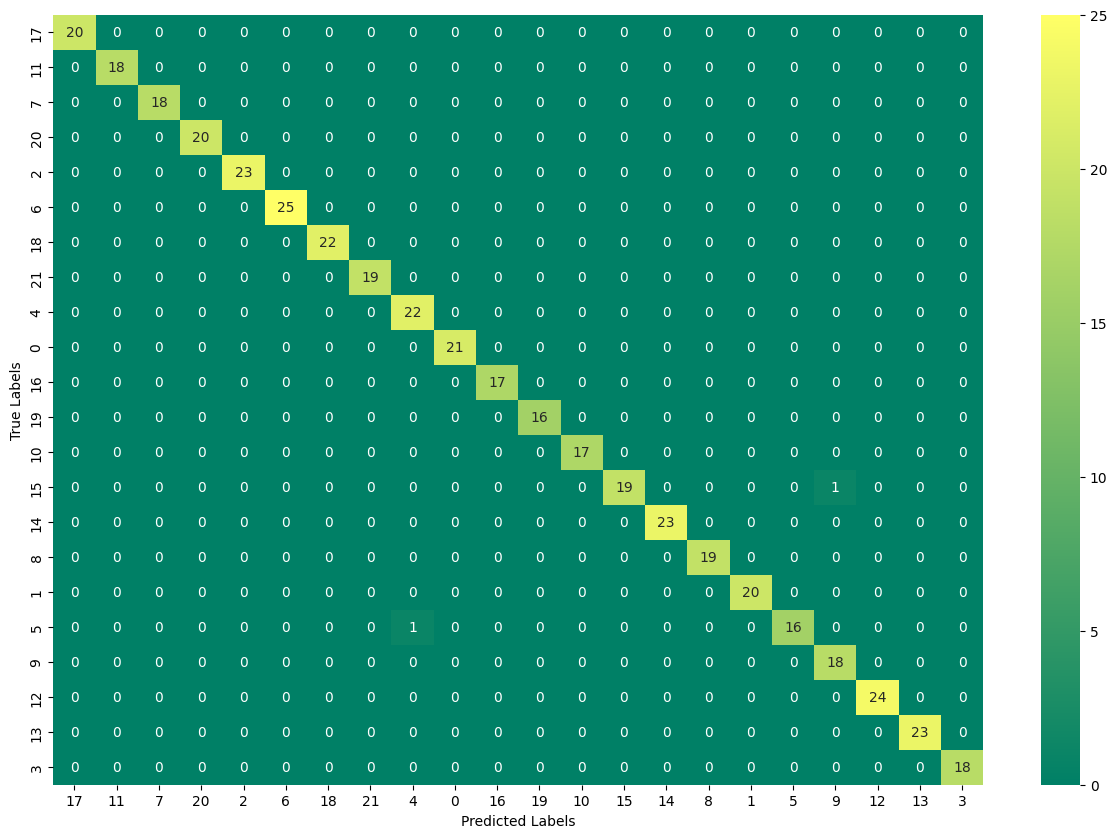

In [ ]:
y_pred = best_logistic_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy(np.array(y_test), y_pred)

0.9954545454545455

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged Precision score: 0.9956313709174119
Micro-Averaged Precision score: 0.9954545454545455
Macro-averaged recall score: 0.9950534759358288
Micro-Averaged recall score: 0.9954545454545455
Macro-Averaged F1 score: 0.9952184861275769
Micro-Averaged F1 score: 0.9954545454545455


## SVM

In [ ]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'degree': [2, 3], 'kernel': ['poly']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto'], 'kernel': ['sigmoid']}
 ]

cv_model = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', return_train_score=False)

cv_model.fit(X=X_train, y=y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000], 'degree': [2, 3],
                          'kernel': ['poly']},
                         {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['sigmoid']}],
             scoring='accuracy')

In [ ]:
SVM_result = pd.DataFrame(cv_model.cv_results_)
#SVM_result = SVM_result[-logistic_result['mean_test_score'].isnull()]
SVM_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.213770,0.043236,0.041017,0.008791,0.1,scale,rbf,NaN,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.732955,...,0.642045,0.670455,0.664773,0.619318,0.625000,0.664773,0.693182,0.669318,0.034729,18
1,0.273352,0.007728,0.034792,0.002069,0.1,auto,rbf,NaN,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.045455,...,0.045455,0.045455,0.045455,0.136364,0.102273,0.096591,0.090909,0.069886,0.031945,25
2,0.047137,0.003121,0.022323,0.001036,1,scale,rbf,NaN,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.971591,...,0.977273,0.988636,0.977273,0.965909,0.960227,0.988636,0.965909,0.972727,0.009775,10
3,0.334740,0.031105,0.035579,0.006020,1,auto,rbf,NaN,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.761364,...,0.744318,0.698864,0.744318,0.681818,0.698864,0.772727,0.744318,0.731818,0.027812,16
4,0.052345,0.015614,0.024454,0.006477,10,scale,rbf,NaN,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.977273,...,0.982955,0.994318,1.000000,0.965909,0.994318,0.994318,0.977273,0.985795,0.009923,8
5,0.454555,0.103045,0.044056,0.009367,10,auto,rbf,NaN,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.778409,...,0.789773,0.755682,0.778409,0.721591,0.727273,0.795455,0.761364,0.761932,0.023212,13
6,0.023648,0.000636,0.009795,0.000341,100,scale,rbf,NaN,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.994318,...,0.982955,0.994318,0.994318,0.982955,0.994318,0.988636,0.988636,0.989773,0.004252,6
7,0.323016,0.008081,0.034875,0.002682,100,auto,rbf,NaN,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.778409,...,0.789773,0.755682,0.778409,0.721591,0.727273,0.795455,0.761364,0.761932,0.023212,13
8,0.025673,0.005429,0.009297,0.000212,1000,scale,rbf,NaN,"{'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}",0.988636,...,0.982955,0.994318,1.000000,0.982955,1.000000,0.994318,0.988636,0.992614,0.006250,2
9,0.322114,0.010655,0.033681,0.000901,1000,auto,rbf,NaN,"{'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}",0.778409,...,0.789773,0.755682,0.778409,0.721591,0.727273,0.795455,0.761364,0.761932,0.023212,13


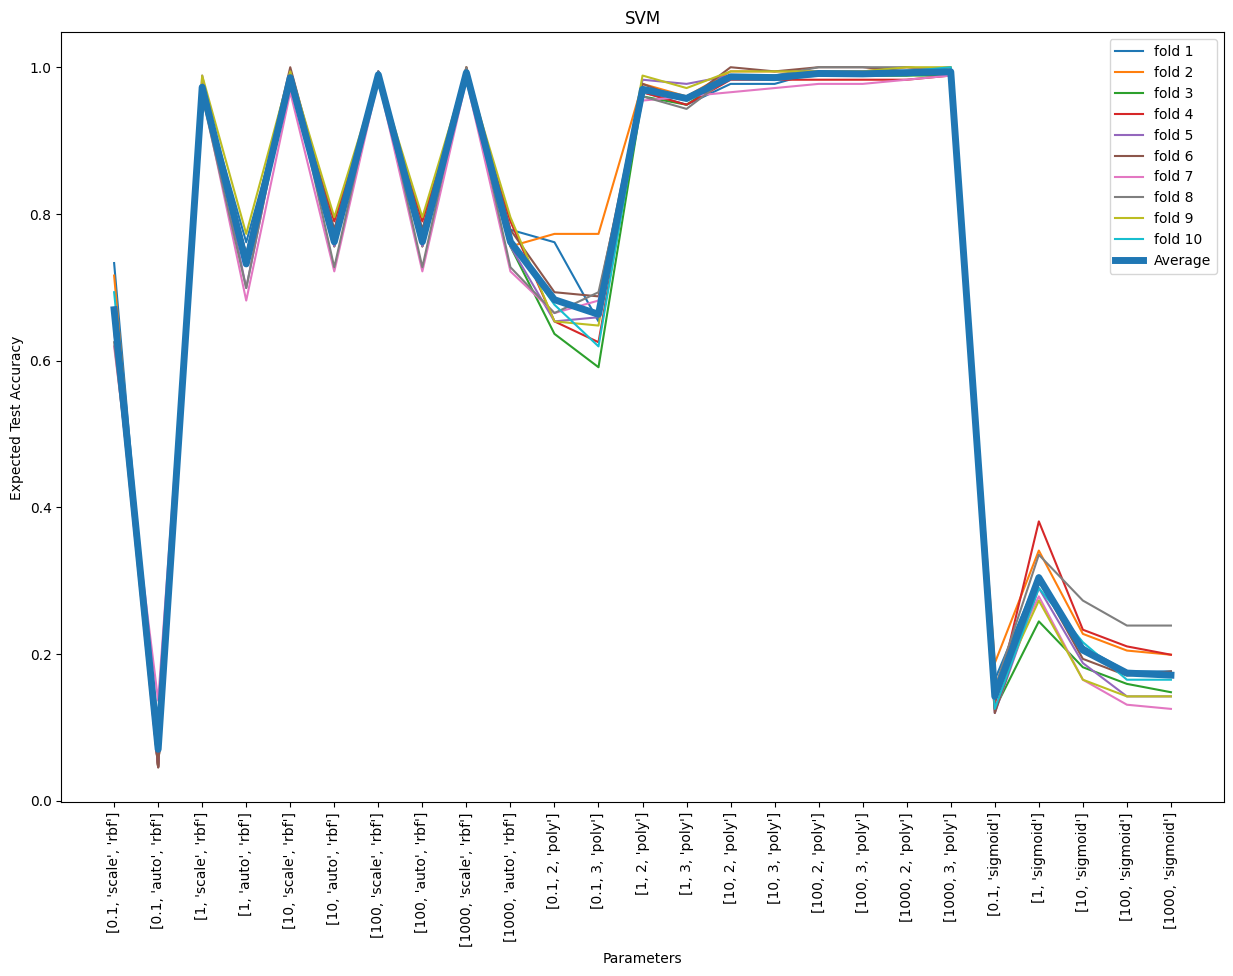

In [ ]:
labels = list()
for i in range(len(SVM_result['params'])):
  labels.append(list(SVM_result['params'][i].values()))
x = range(25)
y_1 = SVM_result['split0_test_score']
y_2 = SVM_result['split1_test_score']
y_3 = SVM_result['split2_test_score']
y_4 = SVM_result['split3_test_score']
y_5 = SVM_result['split4_test_score']
y_6 = SVM_result['split5_test_score']
y_7 = SVM_result['split6_test_score']
y_8 = SVM_result['split7_test_score']
y_9 = SVM_result['split8_test_score']
y_10 = SVM_result['split9_test_score']
y_avg = SVM_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("SVM")
plt.show()

In [ ]:
cv_model.best_params_

{'C': 1000, 'degree': 3, 'kernel': 'poly'}

In [ ]:
best_SVM_model = SVC(C=1000, kernel='poly', degree=3)
best_SVM_model.fit(X_train, y_train)

SVC(C=1000, kernel='poly')

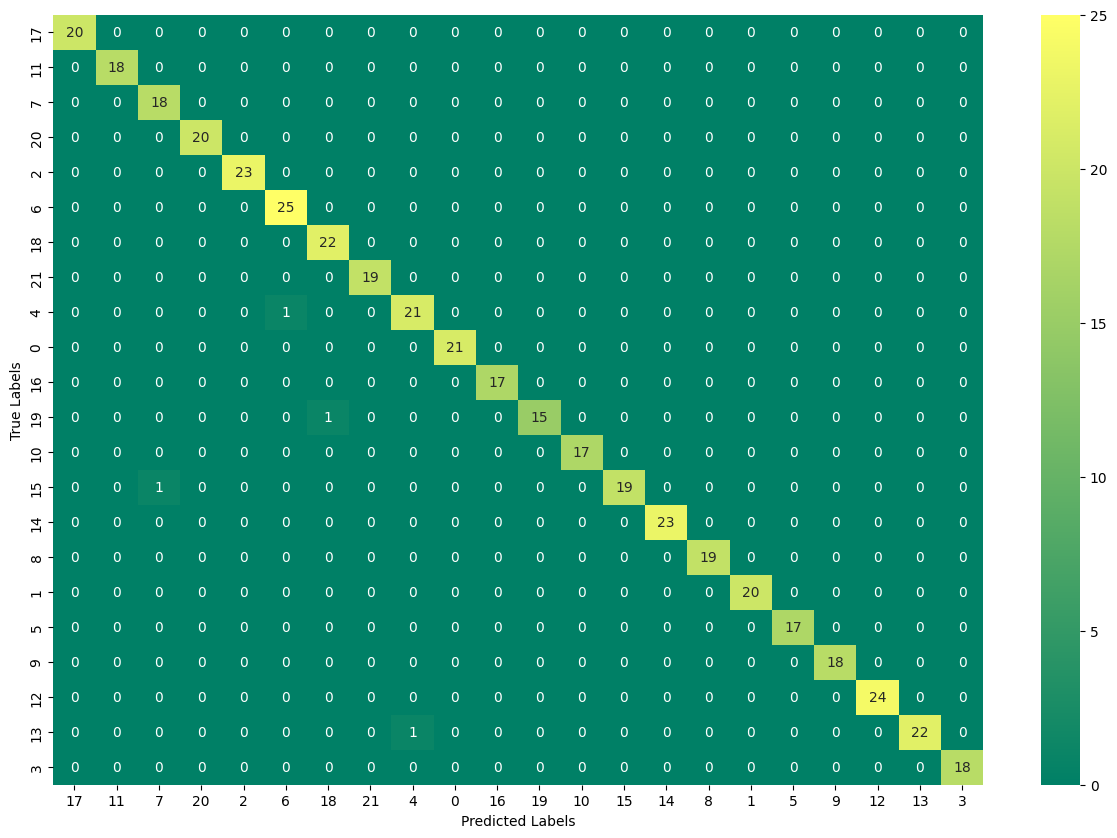

In [ ]:
y_pred = cv_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy(np.array(y_test), y_pred)

0.990909090909091

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged Precision score: 0.9918170034666809
Micro-Averaged Precision score: 0.990909090909091
Macro-averaged recall score: 0.9908439633489041
Micro-Averaged recall score: 0.990909090909091
Macro-Averaged F1 score: 0.9911621386263442
Micro-Averaged F1 score: 0.990909090909091


## Decision Tree

In [ ]:
param_grid = dict(criterion = ['gini', 'entropy'],
                  max_depth = [4,6,8,10,12],
                  min_samples_leaf = range(2, 5),
                  min_samples_split = range(2, 5))
print(param_grid)

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

{'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 10, 12], 'min_samples_leaf': range(2, 5), 'min_samples_split': range(2, 5)}


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 12],
                         'min_samples_leaf': range(2, 5),
                         'min_samples_split': range(2, 5)},
             scoring='accuracy')

In [ ]:
DT_result = pd.DataFrame(grid.cv_results_)
DT_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009838,0.002600,0.002576,0.000415,gini,4,2,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.278409,...,0.272727,0.272727,0.272727,0.272727,0.278409,0.272727,0.329545,0.280114,0.016672,82
1,0.008485,0.000285,0.002690,0.000678,gini,4,2,3,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.278409,...,0.272727,0.272727,0.272727,0.272727,0.278409,0.272727,0.329545,0.280114,0.016672,82
2,0.009415,0.001267,0.002741,0.000522,gini,4,2,4,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.278409,...,0.272727,0.272727,0.272727,0.272727,0.278409,0.272727,0.329545,0.280114,0.016672,82
3,0.008873,0.001076,0.002467,0.000403,gini,4,3,2,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.278409,...,0.272727,0.272727,0.272727,0.272727,0.278409,0.272727,0.329545,0.280114,0.016672,82
4,0.008382,0.000411,0.002265,0.000106,gini,4,3,3,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.278409,...,0.272727,0.272727,0.272727,0.272727,0.278409,0.272727,0.329545,0.280114,0.016672,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.015860,0.000306,0.002474,0.000069,entropy,12,3,3,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.988636,...,0.982955,0.994318,0.994318,0.994318,0.994318,0.988636,0.988636,0.990341,0.003638,23
86,0.016053,0.000421,0.002620,0.000256,entropy,12,3,4,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.982955,...,0.982955,0.994318,0.988636,0.994318,0.994318,0.988636,0.994318,0.989773,0.004252,25
87,0.016595,0.001781,0.002701,0.000319,entropy,12,4,2,"{'criterion': 'entropy', 'max_depth': 12, 'min...",1.000000,...,0.982955,0.994318,0.988636,0.994318,0.994318,0.988636,0.988636,0.990909,0.004545,16
88,0.015671,0.000093,0.002495,0.000098,entropy,12,4,3,"{'criterion': 'entropy', 'max_depth': 12, 'min...",0.994318,...,0.982955,1.000000,0.994318,0.994318,0.994318,0.988636,0.994318,0.992045,0.004545,9


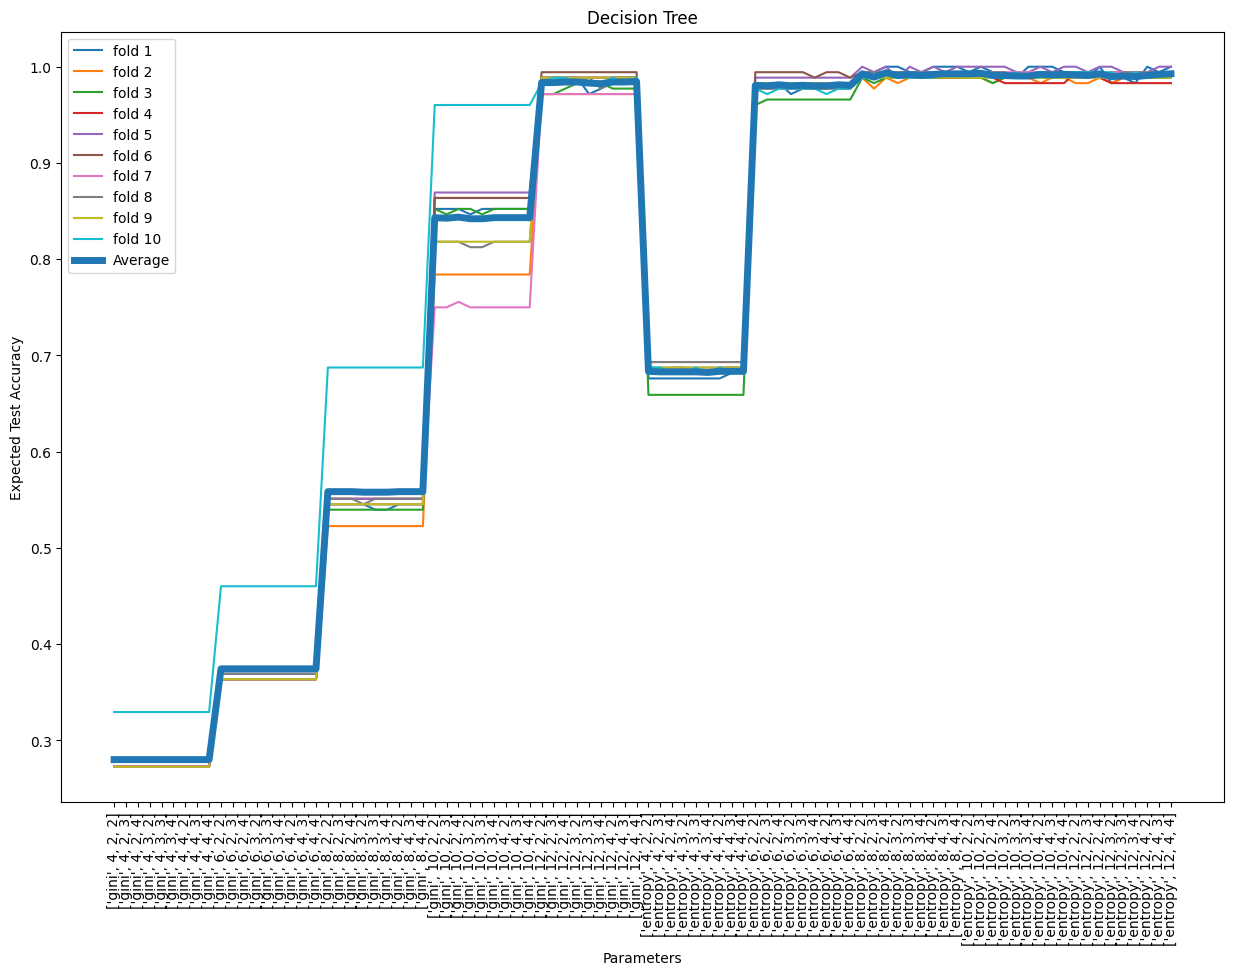

In [ ]:
labels = list()
for i in range(len(DT_result['params'])):
  labels.append(list(DT_result['params'][i].values()))
x = range(90)
y_1 = DT_result['split0_test_score']
y_2 = DT_result['split1_test_score']
y_3 = DT_result['split2_test_score']
y_4 = DT_result['split3_test_score']
y_5 = DT_result['split4_test_score']
y_6 = DT_result['split5_test_score']
y_7 = DT_result['split6_test_score']
y_8 = DT_result['split7_test_score']
y_9 = DT_result['split8_test_score']
y_10 = DT_result['split9_test_score']
y_avg = DT_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("Decision Tree")
plt.show()

In [ ]:
print('Best criterion:', grid.best_estimator_.get_params()['criterion'])
print('Best max_depth:', grid.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', grid.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_samples_split:', grid.best_estimator_.get_params()['min_samples_split'])
print('Best mean test error:', grid.best_score_)

Best criterion: entropy
Best max_depth: 8
Best min_samples_leaf: 2
Best min_samples_split: 4
Best mean test error: 0.99375


In [ ]:
best_DT_model = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2, min_samples_split=4)
best_DT_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2,
                       min_samples_split=4)

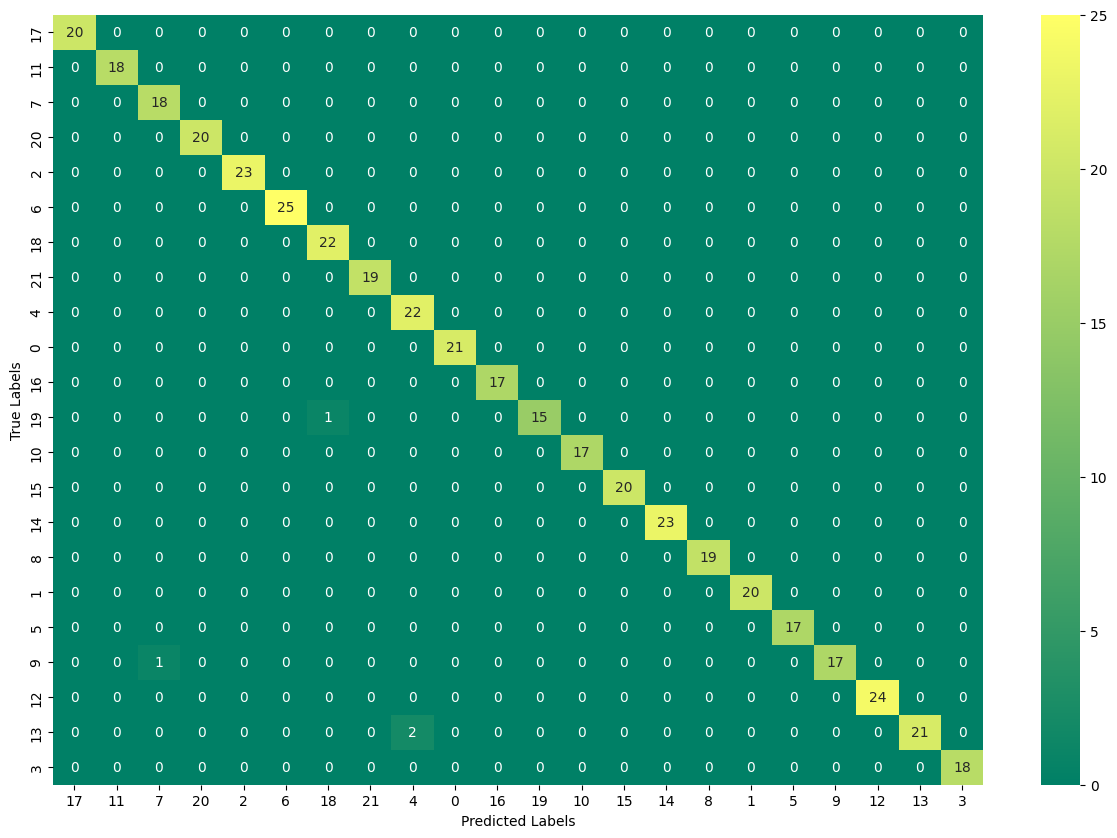

In [ ]:
y_pred = best_DT_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy(np.array(y_test), y_pred)

0.990909090909091

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged Precision score: 0.9918434921295333
Micro-Averaged Precision score: 0.990909090909091
Macro-averaged recall score: 0.9906812692138779
Micro-Averaged recall score: 0.990909090909091
Macro-Averaged F1 score: 0.9909540205154127
Micro-Averaged F1 score: 0.990909090909091


## Neural Network

In [ ]:
class CropDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, csv_file):
        """Initializes instance of class StudentsPerformanceDataset.

        Args:
            csv_file (str): Path to the csv file with the students data.

        """
        df = pd.read_csv(csv_file)

        # Grouping variable names
        #self.categorical = ['label']
        self.target = 'label'

        # One-hot encoding of categorical variables
        self.label_encoder = ce.OrdinalEncoder(cols='label', return_df=True)
        self.students_frame = self.label_encoder.fit_transform(df)
        #self.students_frame = pd.get_dummies(df, prefix=self.categorical)
        #self.students_frame = df
        # Save target and predictors
        self.X = self.students_frame.drop(self.target, axis=1)
        self.y = self.students_frame[self.target]

    def __len__(self):
        return len(self.students_frame)

    def __getitem__(self, idx):
        # Convert idx from tensor to list due to pandas bug (that arises when using pytorch's random_split)
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.X.iloc[idx].values, self.y[idx]]

In [ ]:
class Net(nn.Module):

    def __init__(self, D_in, H=5, D_out=1):
        super().__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x.squeeze()

In [ ]:
def train(csv_file, n_epochs=100):
    """Trains the model.
    Args:
        csv_file (str): Absolute path of the dataset used for training.
        n_epochs (int): Number of epochs to train.
    """
    # Load dataset
    dataset = CropDataset(csv_file)

    # Split into training and test
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size])

    # Dataloaders
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=False)

    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define the model
    D_in, H = 7, 5
    net = Net(D_in, H).to(device)

    # Loss function
    criterion = nn.MSELoss()

    # Optimizer
    optimizer = optim.Adam(net.parameters(), weight_decay=0.0001)

    # Train the net
    loss_per_iter = []
    loss_per_batch = []
    for epoch in range(n_epochs):

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            #print(inputs)
            #print(labels)
            inputs = inputs.to(device)
            labels = torch.tensor(labels).to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Save loss to plot
            running_loss += loss.item()
            loss_per_iter.append(loss.item())

        loss_per_batch.append(running_loss / (i + 1))
        running_loss = 0.0

    # Comparing training to test
    dataiter = iter(testloader)
    inputs, labels = next(dataiter)
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = net(inputs.float())
    print("Root mean squared error")
    print("Training:", np.sqrt(loss_per_batch[-1]))
    print("Test", np.sqrt(criterion(labels.float(), outputs).detach().cpu().numpy()))

    # Plot training loss curve
    plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


<ipython-input-92-f23bcae37ba1>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Root mean squared error
Training: 4.6645672548990085
Test 3.69397


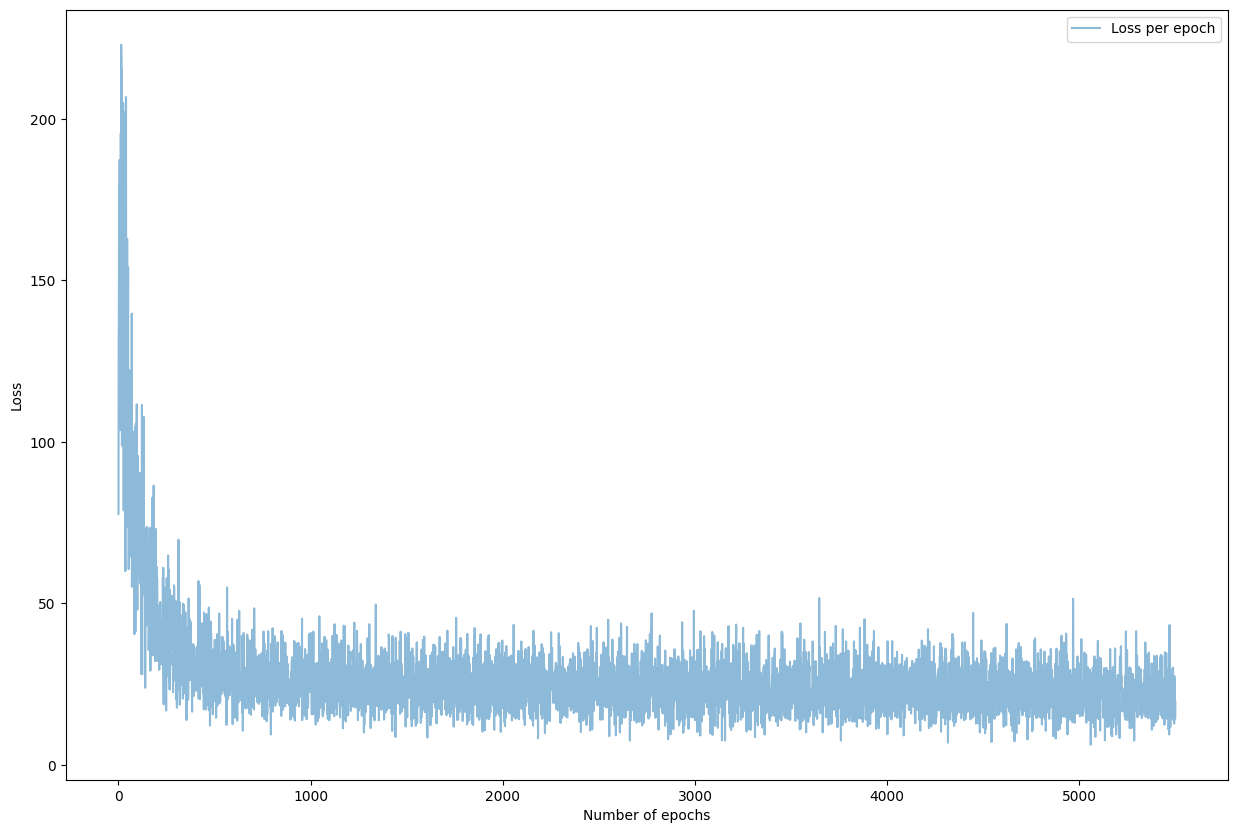

In [ ]:
import argparse
#csv_file = os.path.join(sys.path[0], "StudentsPerformance.csv")
csv_file = io.BytesIO(uploaded['Crop_recommendation.csv'])

# Parsing arguments
parser = argparse.ArgumentParser()
parser.add_argument("--file", "-f", nargs="?", const=csv_file, default=csv_file,
                        help="Dataset file used for training")
parser.add_argument("--epochs", "-e", type=int, nargs="?", default=100, help="Number of epochs to train")
args = parser.parse_args()

# Call the main function of the script
train(csv_file)

In [ ]:
from sklearn.neural_network import MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid = GridSearchCV(MLPClassifier(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                    hidden_layer_sizes=(5, 2), random_state=1)

#clf.fit(train_X, train_y)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:

GridSearchCV(cv=10, estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [ ]:
MLP_result = pd.DataFrame(grid.cv_results_)
MLP_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,6.639936,0.955262,0.005937,0.000999,tanh,0.0001,"(50, 50, 50)",constant,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.937500,0.909091,0.909091,0.937500,0.914773,0.943182,0.960227,0.935227,0.017457,44
1,7.519938,0.950304,0.008216,0.003883,tanh,0.0001,"(50, 50, 50)",constant,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.982955,0.988636,0.965909,1.000000,0.988636,1.000000,0.988636,0.989205,0.009988,16
2,6.876143,0.942983,0.005710,0.000241,tanh,0.0001,"(50, 50, 50)",adaptive,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.914773,0.943182,0.920455,0.954545,0.903409,0.954545,0.920455,0.936932,0.022072,42
3,7.059220,0.909868,0.006774,0.002142,tanh,0.0001,"(50, 50, 50)",adaptive,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,1.000000,0.977273,0.971591,0.982955,0.982955,0.994318,0.994318,0.988636,0.009162,18
4,8.622322,0.836081,0.006801,0.001649,tanh,0.0001,"(50, 100, 50)",constant,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.931818,0.931818,0.943182,0.931818,0.920455,0.948864,0.954545,0.943182,0.014816,41
5,8.555111,1.555328,0.008222,0.004002,tanh,0.0001,"(50, 100, 50)",constant,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.994318,0.988636,0.960227,0.994318,0.988636,1.000000,0.988636,0.989773,0.010720,13
6,8.583244,0.830384,0.007267,0.001604,tanh,0.0001,"(50, 100, 50)",adaptive,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.920455,0.920455,0.914773,0.948864,0.914773,0.960227,0.937500,0.935227,0.021138,44
7,8.605154,1.063909,0.008128,0.003277,tanh,0.0001,"(50, 100, 50)",adaptive,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.982955,0.977273,0.977273,0.982955,1.000000,0.988636,0.994318,0.988068,0.007811,20
8,4.395440,0.668227,0.006682,0.002884,tanh,0.0001,"(100,)",constant,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.937500,0.960227,0.926136,0.954545,0.937500,0.948864,0.971591,0.951705,0.015299,40
9,4.719882,0.803258,0.005766,0.002268,tanh,0.0001,"(100,)",constant,adam,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",...,0.988636,0.994318,0.982955,1.000000,1.000000,1.000000,0.994318,0.994886,0.005360,4


In [ ]:
grid.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

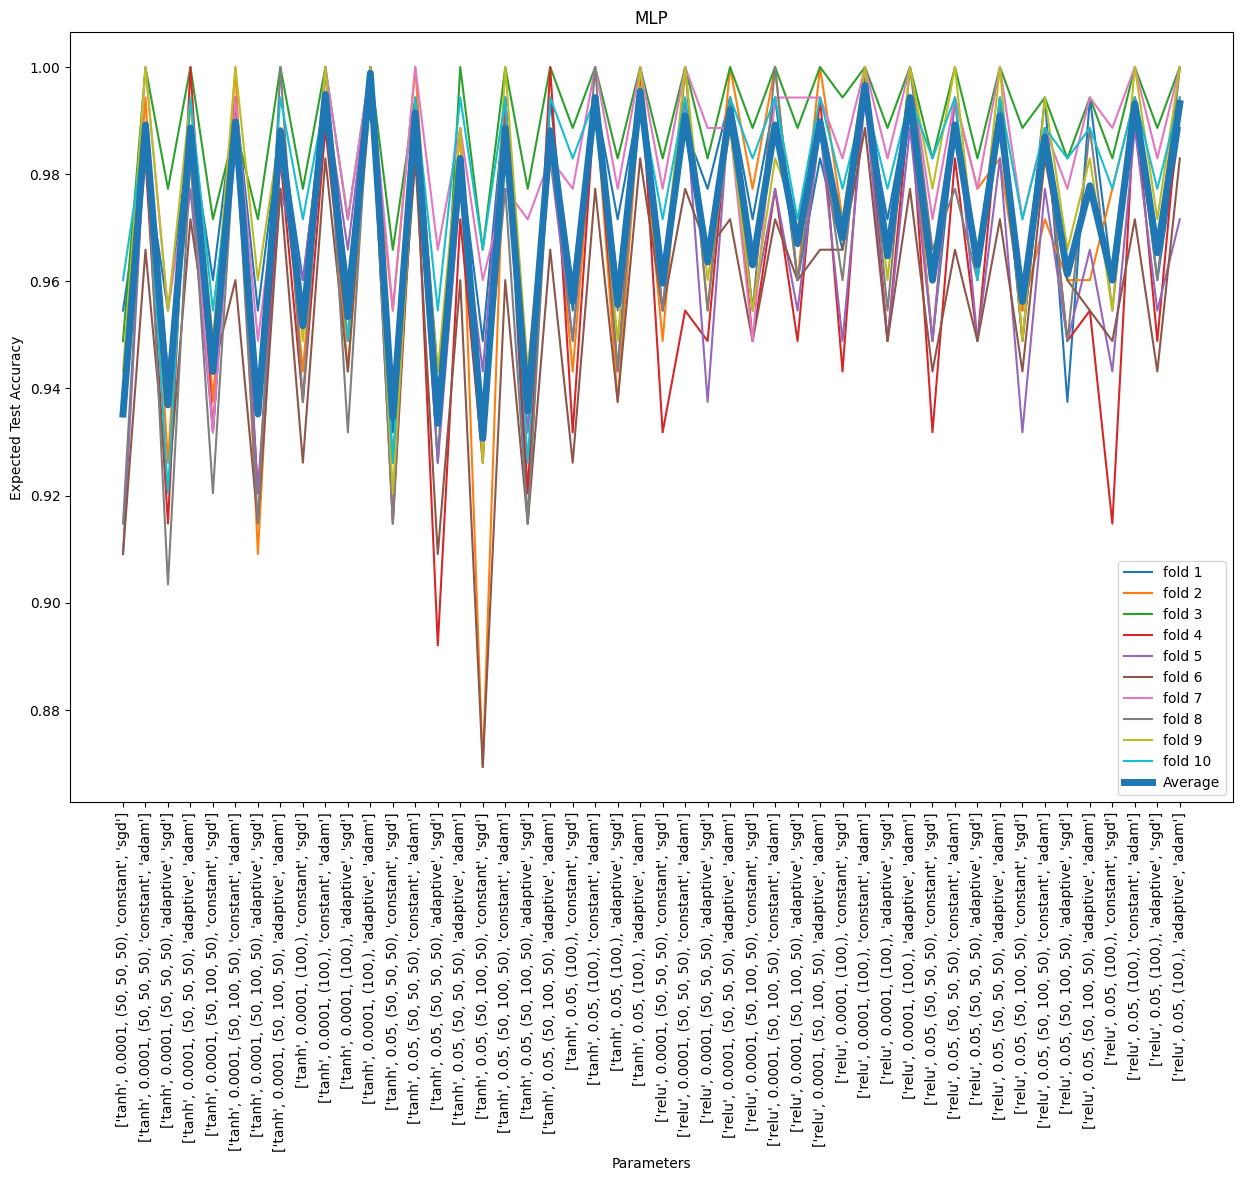

In [ ]:
labels = list()
for i in range(len(MLP_result['params'])):
  labels.append(list(MLP_result['params'][i].values()))
x = range(48)
y_1 = MLP_result['split0_test_score']
y_2 = MLP_result['split1_test_score']
y_3 = MLP_result['split2_test_score']
y_4 = MLP_result['split3_test_score']
y_5 = MLP_result['split4_test_score']
y_6 = MLP_result['split5_test_score']
y_7 = MLP_result['split6_test_score']
y_8 = MLP_result['split7_test_score']
y_9 = MLP_result['split8_test_score']
y_10 = MLP_result['split9_test_score']
y_avg = MLP_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("MLP")
plt.show()

In [ ]:
best_MLP_model = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(100,), learning_rate='adaptive', solver='adam')
best_MLP_model.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', learning_rate='adaptive')

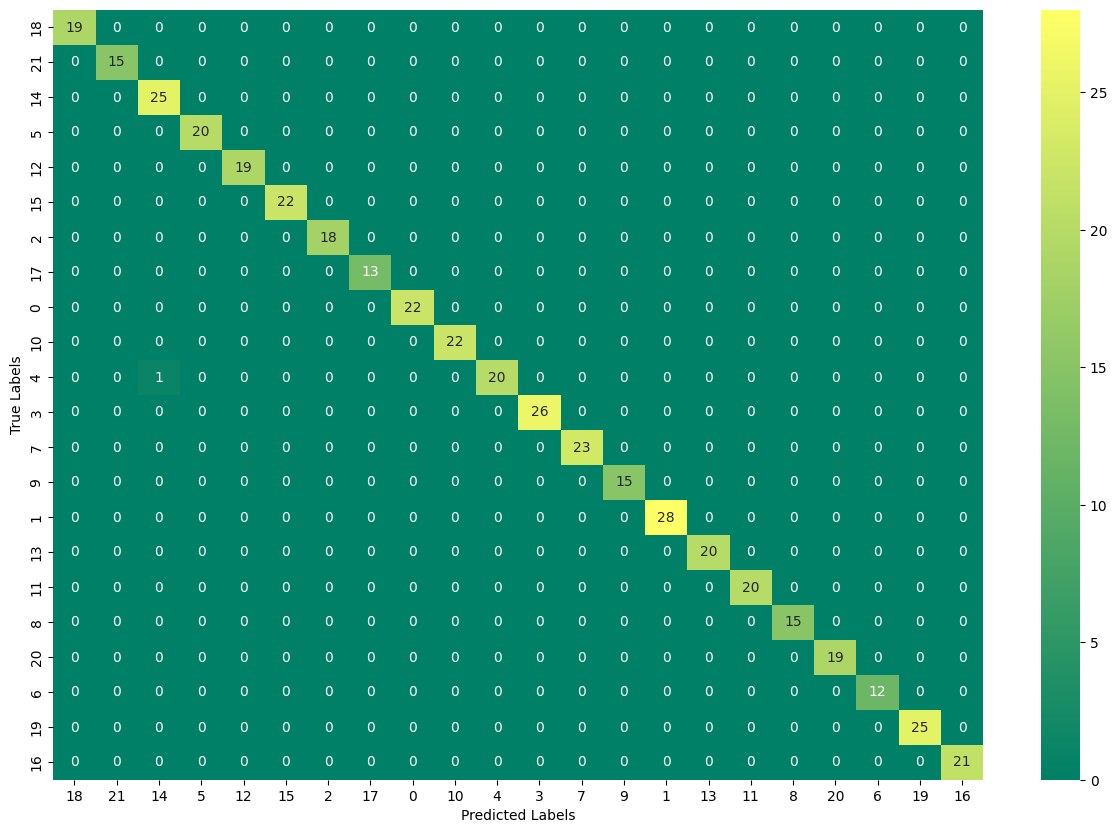

In [ ]:
y_pred = best_MLP_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy(np.array(y_test), y_pred)

0.9977272727272727

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged Precision score: 0.9982517482517482
Micro-Averaged Precision score: 0.9977272727272727
Macro-averaged recall score: 0.9978354978354979
Micro-Averaged recall score: 0.9977272727272727
Macro-Averaged F1 score: 0.9980000869527412
Micro-Averaged F1 score: 0.9977272727272727


# NB

In [ ]:
from sklearn.naive_bayes import GaussianNB
param_grid = {'var_smoothing': np.logspace(0,-9, num=50)}
grid = GridSearchCV(GaussianNB(), param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 6.55128557e-01, 4.29193426e-01, 2.81176870e-01,
       1.84206997e-01, 1.20679264e-01, 7.90604321e-02, 5.17947468e-02,
       3.39322177e-02, 2.22299648e-02, 1.45634848e-02, 9.54095476e-03,
       6.25055193e-03, 4.09491506e-03, 2.68269580e-03, 1.75751062e-03,
       1.15139540e-03, 7.54312006e-04, 4.9...
       7.19685673e-06, 4.71486636e-06, 3.08884360e-06, 2.02358965e-06,
       1.32571137e-06, 8.68511374e-07, 5.68986603e-07, 3.72759372e-07,
       2.44205309e-07, 1.59985872e-07, 1.04811313e-07, 6.86648845e-08,
       4.49843267e-08, 2.94705170e-08, 1.93069773e-08, 1.26485522e-08,
       8.28642773e-09, 5.42867544e-09, 3.55648031e-09, 2.32995181e-09,
       1.52641797e-09, 1.00000000e-09])},
             scoring='accuracy')

In [ ]:
NB_result = pd.DataFrame(grid.cv_results_)
NB_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006091,0.001512,0.003814,0.000529,1.0,{'var_smoothing': 1.0},0.920455,0.806818,0.880682,0.840909,0.823864,0.846591,0.857955,0.875000,0.840909,0.897727,0.859091,0.032817,50
1,0.005574,0.000721,0.003756,0.000452,0.655129,{'var_smoothing': 0.6551285568595508},0.931818,0.852273,0.897727,0.892045,0.903409,0.880682,0.892045,0.880682,0.857955,0.914773,0.890341,0.022876,49
2,0.006238,0.001149,0.004416,0.001132,0.429193,{'var_smoothing': 0.4291934260128778},0.937500,0.892045,0.914773,0.909091,0.926136,0.903409,0.914773,0.897727,0.897727,0.931818,0.912500,0.014641,48
3,0.005479,0.000709,0.003717,0.000624,0.281177,{'var_smoothing': 0.281176869797423},0.954545,0.903409,0.920455,0.914773,0.926136,0.926136,0.931818,0.926136,0.903409,0.931818,0.923864,0.014193,47
4,0.005681,0.000895,0.004344,0.001646,0.184207,{'var_smoothing': 0.1842069969326716},0.965909,0.914773,0.943182,0.931818,0.937500,0.954545,0.937500,0.943182,0.937500,0.948864,0.941477,0.012969,46
5,0.005373,0.000270,0.003597,0.000143,0.120679,{'var_smoothing': 0.12067926406393285},0.977273,0.931818,0.960227,0.948864,0.943182,0.960227,0.960227,0.948864,0.954545,0.960227,0.954545,0.011644,45
6,0.005302,0.000470,0.003449,0.000105,0.07906,{'var_smoothing': 0.07906043210907697},0.977273,0.948864,0.977273,0.971591,0.948864,0.965909,0.965909,0.960227,0.965909,0.977273,0.965909,0.010164,42
7,0.005062,0.000160,0.003432,0.000132,0.051795,{'var_smoothing': 0.0517947467923121},0.982955,0.965909,0.982955,0.977273,0.954545,0.965909,0.971591,0.971591,0.965909,0.977273,0.971591,0.008427,39
8,0.005093,0.000273,0.003633,0.000623,0.033932,{'var_smoothing': 0.03393221771895328},0.977273,0.971591,0.982955,0.982955,0.965909,0.971591,0.982955,0.971591,0.994318,0.977273,0.977841,0.007811,37
9,0.005168,0.000241,0.003403,0.000075,0.02223,{'var_smoothing': 0.022229964825261943},0.982955,0.971591,0.982955,0.988636,0.977273,0.971591,0.982955,0.971591,1.000000,0.982955,0.981250,0.008447,35


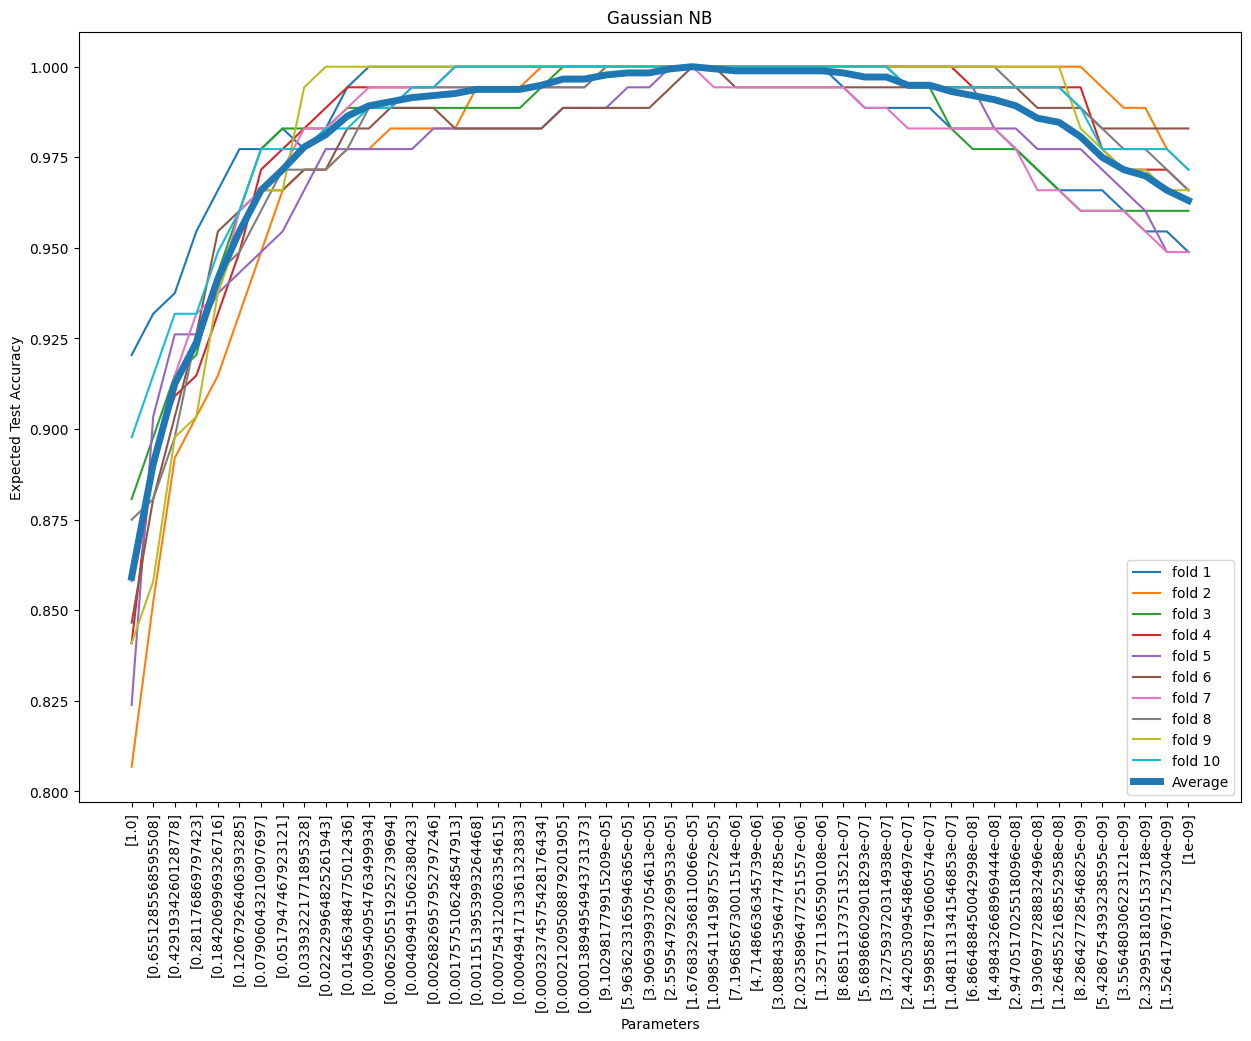

In [ ]:
labels = list()
for i in range(len(NB_result['params'])):
  labels.append(list(NB_result['params'][i].values()))
x = range(50)
y_1 = NB_result['split0_test_score']
y_2 = NB_result['split1_test_score']
y_3 = NB_result['split2_test_score']
y_4 = NB_result['split3_test_score']
y_5 = NB_result['split4_test_score']
y_6 = NB_result['split5_test_score']
y_7 = NB_result['split6_test_score']
y_8 = NB_result['split7_test_score']
y_9 = NB_result['split8_test_score']
y_10 = NB_result['split9_test_score']
y_avg = NB_result['mean_test_score']

# plot lines
plt.plot(x, y_1, label = "fold 1")
plt.plot(x, y_2, label = "fold 2")
plt.plot(x, y_3, label = "fold 3")
plt.plot(x, y_4, label = "fold 4")
plt.plot(x, y_5, label = "fold 5")
plt.plot(x, y_6, label = "fold 6")
plt.plot(x, y_7, label = "fold 7")
plt.plot(x, y_8, label = "fold 8")
plt.plot(x, y_9, label = "fold 9")
plt.plot(x, y_10, label = "fold 10")
plt.plot(x, y_avg, label = "Average", linewidth=5)
plt.xticks(x, labels, rotation='vertical')
plt.legend()
plt.xlabel("Parameters")
plt.ylabel("Expected Test Accuracy")
plt.title("Gaussian NB")
plt.show()

In [ ]:
grid.best_params_

{'var_smoothing': 1.6768329368110066e-05}

In [ ]:
best_NB_model = GaussianNB(var_smoothing = 1.6768329368110066e-05)
best_NB_model.fit(X_train, y_train)

GaussianNB(var_smoothing=1.6768329368110066e-05)

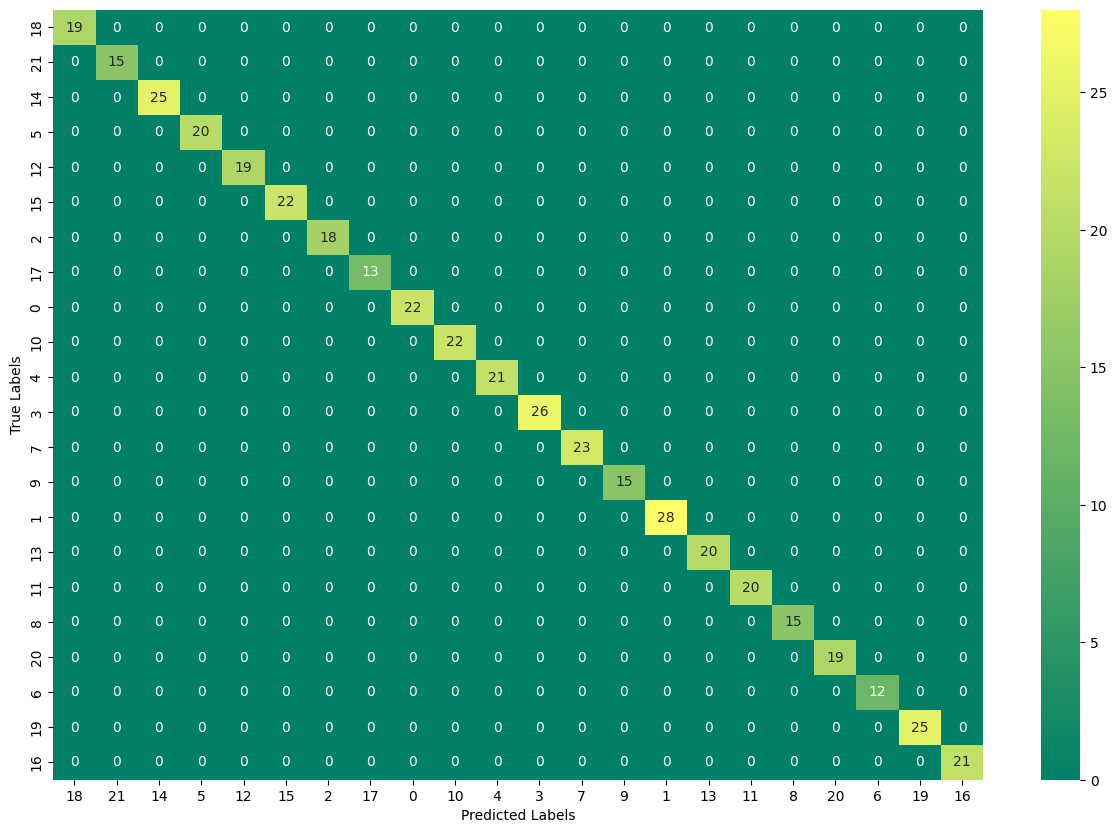

In [ ]:
y_pred = best_NB_model.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = y_test.unique(), yticklabels = y_test.unique(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
accuracy(np.array(y_test), y_pred)

1.0

In [ ]:
macro_averaged_precision = precision_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged Precision score: {macro_averaged_precision}")
micro_averaged_precision = precision_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged Precision score: {micro_averaged_precision}")
macro_averaged_recall = recall_score(y_test, y_pred, average = 'macro')
print(f"Macro-averaged recall score: {macro_averaged_recall}")
micro_averaged_recall = recall_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged recall score: {micro_averaged_recall}")
macro_averaged_f1 = f1_score(y_test, y_pred, average = 'macro')
print(f"Macro-Averaged F1 score: {macro_averaged_f1}")
micro_averaged_f1 = f1_score(y_test, y_pred, average = 'micro')
print(f"Micro-Averaged F1 score: {micro_averaged_f1}")

Macro-Averaged Precision score: 1.0
Micro-Averaged Precision score: 1.0
Macro-averaged recall score: 1.0
Micro-Averaged recall score: 1.0
Macro-Averaged F1 score: 1.0
Micro-Averaged F1 score: 1.0


In [ ]:
X_test

,N_SOIL,P_SOIL,K_SOIL,TEMPERATURE,HUMIDITY,ph,RAINFALL,STATE_Andaman and Nicobar,STATE_Andhra Pradesh,STATE_Assam,...,STATE_Pondicherry,STATE_Punjab,STATE_Rajasthan,STATE_Tamil Nadu,STATE_Telangana,STATE_Tripura,STATE_Uttar Pradesh,STATE_Uttrakhand,STATE_West Bengal,CROP_PRICE
222,31,78,76,17.572121,14.999275,8.519976,89.310507,0,0,0,...,0,0,0,0,0,0,0,0,0,1250
747,55,67,16,34.373291,69.693664,6.596719,70.271847,0,0,0,...,0,0,0,0,0,0,0,0,0,4860
712,52,63,19,29.589490,68.321768,6.928899,67.530212,0,0,0,...,0,0,0,0,0,0,0,0,0,1300
814,39,78,15,21.354995,62.601363,5.925392,41.782198,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1605,26,27,10,28.069032,92.914873,6.079998,114.133942,0,0,0,...,0,0,0,0,0,0,1,0,0,440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,14,29,32,35.636273,48.970478,6.942520,97.519520,0,0,0,...,0,1,0,0,0,0,0,0,0,1200
621,31,53,16,28.742010,85.816759,6.452006,48.545986,0,0,0,...,0,0,0,0,0,0,0,0,0,3500
2117,104,20,26,27.227837,52.952618,7.493192,175.726027,0,0,0,...,0,0,0,0,0,0,0,0,1,800
870,26,66,22,18.064861,65.103435,6.300479,51.549228,0,0,0,...,0,0,0,0,0,0,0,0,0,3800


In [ ]:
features = X_test.columns

In [ ]:
len(features)

34

In [ ]:
NB_perm_importance = permutation_importance(best_NB_model, X_test, y_test)
sorted_idx = NB_perm_importance.importances_mean.argsort()
print(len(sorted_idx))
#plt.figure(figsize=(8,7))
#plt.barh(features[sorted_idx], logistic_perm_importance.importances_mean[sorted_idx])
#plt.xlabel("Feature Importance")

34
